<a href="https://colab.research.google.com/github/znoble360/cap4630/blob/master/HW_4/HW_4_P3_b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Resources:

code derived from https://colab.research.google.com/drive/1F-RWvoxH8MmT7c1UmNy41iuOp-ejiLoF

I improved the validation accuracy for the final model from 92.4 to 93.9 by doubling the number of nodes in the classifier layer.

# Fine-tuning Xception 

## Feature extraction

## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-21 03:25:41--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   109MB/s    in 0.6s    

2020-04-21 03:25:41 (109 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build network with Xception convolution base and custom densely connected layers

### Load the convolutional base

In [4]:
from keras.applications import Xception

conv_base = Xception(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

Using TensorFlow backend.


### Freeze the convolutional base

In [0]:
conv_base.trainable = False

### Concatenate the convolutional base and densely connected layers

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               26214912  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 47,076,905
Trainable params: 26,215,425
Non-trainable params: 20,861,480
_________________________________________________________________


## Train the model end to end with frozen convolutional base

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=10,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
10/10 [==============================] - 8s 818ms/step - loss: 0.6020 - acc: 0.6700 - val_loss: 0.1353 - val_acc: 0.8430
Epoch 2/30
10/10 [==============================] - 4s 399ms/step - loss: 0.4949 - acc: 0.7250 - val_loss: 0.0734 - val_acc: 0.9470
Epoch 3/30
10/10 [==============================] - 4s 399ms/step - loss: 0.5485 - acc: 0.7000 - val_loss: 0.0349 - val_acc: 0.9450
Epoch 4/30
10/10 [==============================] - 4s 400ms/step - loss: 0.3701 - acc: 0.8250 - val_loss: 0.3233 - val_acc: 0.9340
Epoch 5/30
10/10 [==============================] - 4s 403ms/step - loss: 0.4332 - acc: 0.7800 - val_loss: 0.0972 - val_acc: 0.9320
Epoch 6/30
10/10 [==============================] - 4s 398ms/step - loss: 0.4226 - acc: 0.8050 - val_loss: 0.0756 - val_acc: 0.9530
Epoch 7/30
10/10 [==============================] - 4s 404ms/step - loss: 0.4016 - acc: 0.8050 - val_loss: 0.3306 - val_acc:

## Display curves of loss and accuracy during training

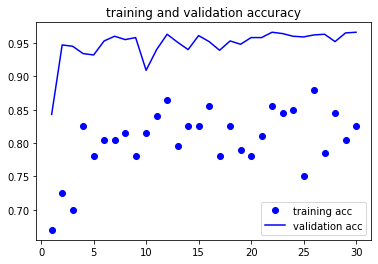

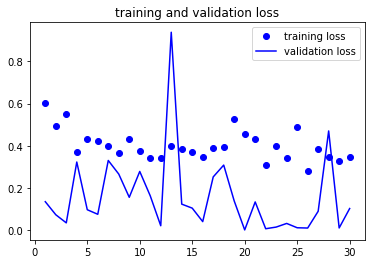

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

In [10]:
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block12_sepconv1_act':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  if layer.name == 'block12_sepconv3_bn':
    set_trainable = True
  else:
    layer.trainable = False

In [12]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=10,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
10/10 [==============================] - 8s 751ms/step - loss: 0.2733 - acc: 0.8600 - val_loss: 0.1357 - val_acc: 0.9670
Epoch 2/100
10/10 [==============================] - 4s 410ms/step - loss: 0.3492 - acc: 0.8750 - val_loss: 0.1321 - val_acc: 0.9610
Epoch 3/100
10/10 [==============================] - 4s 415ms/step - loss: 0.3128 - acc: 0.8700 - val_loss: 0.2676 - val_acc: 0.9610
Epoch 4/100
10/10 [==============================] - 4s 414ms/step - loss: 0.2841 - acc: 0.8800 - val_loss: 0.0143 - val_acc: 0.9330
Epoch 5/100
10/10 [==============================] - 4s 412ms/step - loss: 0.2872 - acc: 0.8500 - val_loss: 0.1988 - val_acc: 0.9570
Epoch 6/100
10/10 [==============================] - 4s 416ms/step - loss: 0.2821 - acc: 0.8400 - val_loss: 0.0099 - val_acc: 0.9430
Epoch 7/100
10/10 [==============================] - 4s 411ms/step - loss: 0.2689 - acc: 0.8700 - val_loss: 0.0112 - val_acc: 0.9620
Epoch 8/100
10/10 [==============================] - 4s 418ms/step - 

## Display learning curves during fine-tuning

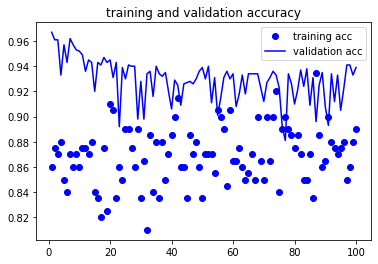

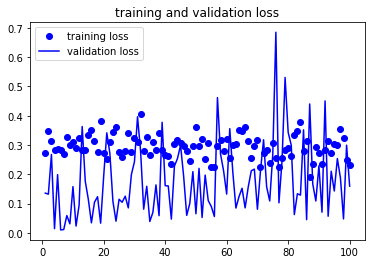

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [15]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.15944518148899078
Validation accuracy: 0.9390000104904175


## Save the model

In [0]:
model_fname = 'cats_and_dogs_small_4.h5' 
model.save(model_fname)